In [9]:
# Import packages
import os
import pandas as pd
import numpy as np
import itertools
import collections
import networkx as nx
import six
import matplotlib.pyplot as plt
import seaborn as sns
import emoji as em
#import fasttext

from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split

import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shari\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
# Check language
#!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
# Load dataset
df = pd.read_csv('D:\Thesis_Code\Suicide_Detection_original_dataset\Suicide_Detection.csv', index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [16]:
#Checking for null values
df.isnull().sum()

text     0
class    0
dtype: int64

In [160]:
plt.style.use('Solarize_Light2')

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64
class
suicide        0.5
non-suicide    0.5
Name: proportion, dtype: float64


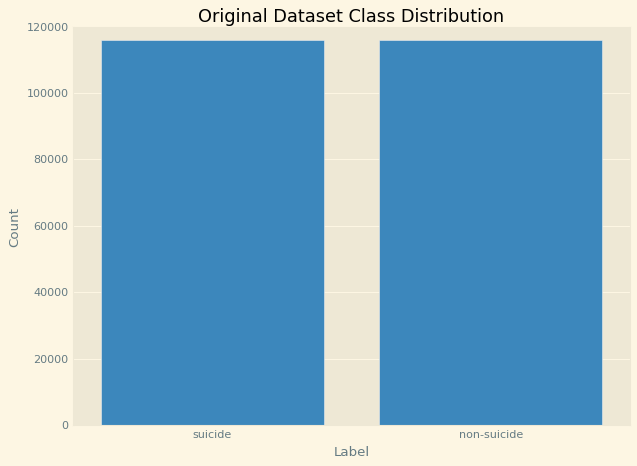

In [159]:
# sucide v/s non suicidal cases 

print(df['class'].value_counts())
print(df['class'].value_counts(normalize=True))

sns.countplot(x=df['class'])
plt.title('Original Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [18]:
# Check lowercase
lowercase = df['text'].str.islower()
print(lowercase.value_counts())

text
False    214395
True      17679
Name: count, dtype: int64


In [19]:
#Check extra whitespace

extra_whitespace = df['text'].str.match('\s\s+')
print(extra_whitespace.value_counts())

text
False    232073
True          1
Name: count, dtype: int64


In [22]:
# Check URL
url = df['text'].str.contains("http")
print(url.value_counts())

df['text'][url == True]

text
False    224921
True       7153
Name: count, dtype: int64


24        Do you sleep with Socks On,and how do you feel...
50        7 YearsGuys, I've been here before, a few year...
109       Check out this new horror short I made https:/...
127       All I think about is death, I lost my life I l...
160       i got a new tat tonight im vry happy w it :DD ...
                                ...                        
231914    [Interactive Quiz] On a lighter note, see if y...
231944    How to get a credit card as a teen and build c...
231961    This is the link to my Youtube and SoundCloud,...
232030    this post is for the girls with a youtube chan...
232069    If you don't like rock then your not going to ...
Name: text, Length: 7153, dtype: object

In [23]:
# Check mentions
mention = df['text'].str.match('@(\w+)')
print(mention.value_counts())

df['text'][mention == True]

text
False    232072
True          2
Name: count, dtype: int64


70950    @everyone do you like dick? balls? Maybe cock ...
78446    @everyone @everyone Oh.......\n\n this doesn't...
Name: text, dtype: object

In [24]:
# Check hashtags
hashtag = df['text'].str.match('#(\w+)')
print(hashtag.value_counts())

# df['text'][hashtag == True]

text
False    232061
True         13
Name: count, dtype: int64


In [25]:
# Check subreddit tag
subreddit = df['text'].str.match('r/(\w+)')
print(subreddit.value_counts())

# df['text'][subreddit == True]

text
False    231990
True         84
Name: count, dtype: int64


In [26]:
# Check users tag
users = df['text'].str.match('u/(\w+)')
print(users.value_counts())

# df['text'][users == True]

text
False    231859
True        215
Name: count, dtype: int64


In [27]:

# Check special characters
special_characters = df['text'].str.match('[^0-9a-zA-Z]+')
print(special_characters.value_counts())

# df['text'][special_characters == True]

text
False    229638
True       2436
Name: count, dtype: int64


In [45]:
import emoji

# Check emojis
def text_has_emoji(text):
    for character in text:
        if character in emoji.EMOJI_DATA:
            return True
    return False

emoji = df['text'].apply(text_has_emoji)
print(emoji.value_counts())

df['text'][emoji == True]

text
False    221956
True      10118
Name: count, dtype: int64


94        Shopping IS AWFUL Finally was allowed to go ou...
127       All I think about is death, I lost my life I l...
143       here's my debate for why violent video games r...
151       God damn I wish I could be pegged I just wanna...
158       I just found out doing Yoga wrong can lead to ...
                                ...                        
231924    the audiotree live version of liquid smooth by...
231939    Holy shit guys I need to keep up my fitness to...
231943    It’s my birthday So take some cake and stay a ...
231975    I can’t believe I have to leave this out here....
232071    pee probably tastes like salty tea😏💦‼️ can som...
Name: text, Length: 10118, dtype: object

In [55]:
import emoji
emj = df['text'].apply(lambda x: emoji.emoji_count(x) if isinstance(x, str) else 0)
emj


0         0
1         0
2         0
3         0
4         0
         ..
232069    0
232070    0
232071    5
232072    0
232073    0
Name: text, Length: 232074, dtype: int64

## Cleaned Dataset - analysis

In [71]:
# Load dataset
clean_df = pd.read_csv('suicide_detection_final_cleaned.csv', header=0)
clean_df

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fucking god annoying
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,It ends tonight.I can’t do it anymore. \nI quit.,suicide,end tonight not anymore quit
...,...,...,...
175649,I did something today I went sledding with my ...,non-suicide,today went sled friend not like pretty big mil...
175650,If you don't like rock then your not going to ...,non-suicide,not like rock not go
175651,You how you can tell i have so many friends an...,non-suicide,tell friend not lonely deprive buy little nigh...
175652,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea drink pee co...


In [72]:
# Check for null values
clean_df.isnull().sum()

text            0
class           0
cleaned_text    0
dtype: int64

In [73]:
# Split dataset into train and test sets 
train_data, test_data = train_test_split(clean_df,
                                         test_size=0.2, 
                                         random_state=42,
                                         stratify=clean_df['class'])

In [74]:

# Split train set into classes
train_data_suicidal = train_data[train_data['class'] == "suicide"]
train_data_nonsuicidal = train_data[train_data['class'] == "non-suicide"]

## full dataset unncluding train and test set

class
non-suicide    107296
suicide         68358
Name: count, dtype: int64
class
non-suicide    0.610837
suicide        0.389163
Name: proportion, dtype: float64


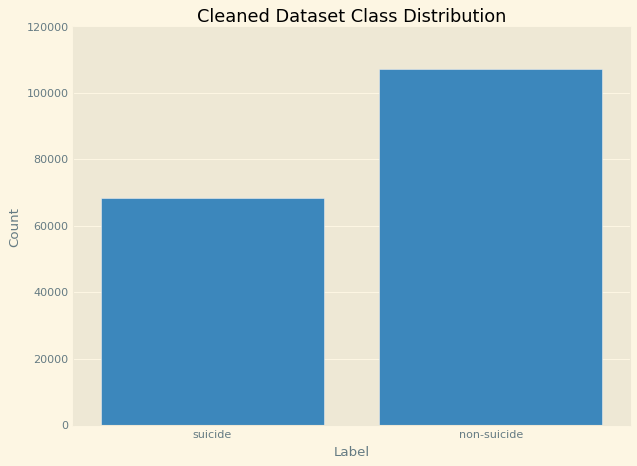

In [156]:

# Check class distribution
print(clean_df['class'].value_counts())
print(clean_df['class'].value_counts(normalize=True))

sns.countplot(x=clean_df['class'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### only train set

class
non-suicide    85837
suicide        54686
Name: count, dtype: int64
class
non-suicide    0.61084
suicide        0.38916
Name: proportion, dtype: float64


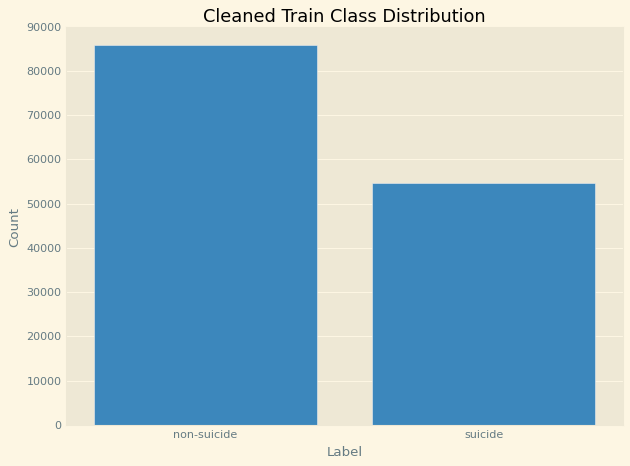

In [157]:
#Check class distribution
print(train_data['class'].value_counts())
print(train_data['class'].value_counts(normalize=True))

sns.countplot(x=train_data['class'])
plt.title('Cleaned Train Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## SUICIDAL TEXT 

In [78]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_suicidal['cleaned_text'])

In [91]:
token_df = pd.DataFrame (tokenizer.word_counts.items())

In [97]:
tokenizer.word_counts.items()

odict_items([('think', 19185), ('go', 20327), ('end', 11979), ('tonight', 2654), ('not', 110441), ('want', 41308), ('failure', 1350), ('anymore', 12383), ('amp', 980), ('web', 478), ('posterity', 3), ('case', 471), ('interested', 230), ('rationale', 2), ('stuck', 342), ('post', 4370), ('explain', 622), ('gone', 22), ('throw', 818), ('lose', 4562), ('gov', 6), ('take', 3905), ('know', 26067), ('live', 12389), ('deal', 2214), ('bad', 9384), ('hand', 810), ('right', 6469), ('useless', 1007), ('attention', 730), ('whore', 78), ('tell', 8657), ('horrible', 981), ('lash', 44), ('internet', 400), ('family', 7004), ('friend', 12428), ('tired', 6155), ('action', 325), ('fitting', 25), ('pass', 1143), ('away', 3956), ('complication', 17), ('hit', 1013), ('depression', 3916), ('fine', 793), ('week', 3493), ('maybe', 3337), ('row', 81), ('huge', 391), ('wave', 118), ('usually', 463), ('cry', 2766), ('anger', 347), ('suicidal', 5981), ('thought', 5717), ('sick', 2097), ('people', 13652), ('hate', 7

In [103]:
token_df = pd.DataFrame (tokenizer.word_counts.items() , columns=['word','count']).sort_values(by='count', ascending=False)
token_df.head(20)

,word,count
4,not,110441
5,want,41308
117,feel,30955
22,know,26067
128,like,24530
72,life,24447
1,go,20327
82,no,20138
0,think,19185
233,kill,15150


C:\Users\shari\AppData\Local\Temp\ipykernel_32956\266749899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count',y='word',data=token_df.iloc[:20],palette='husl' )


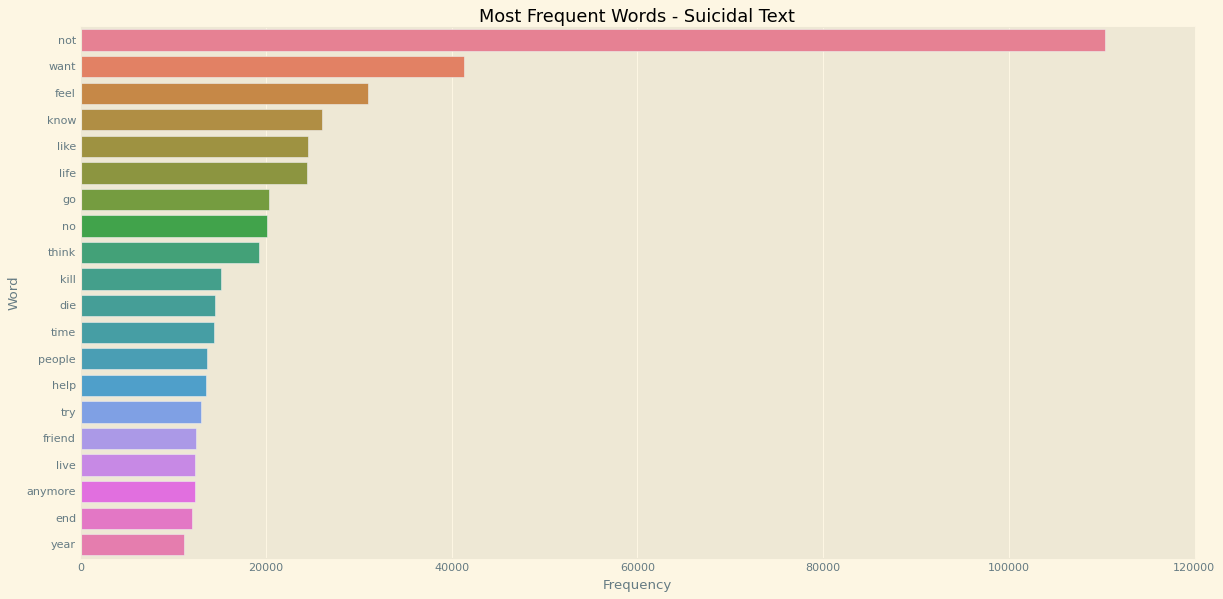

In [155]:
plt.figure(figsize=(16, 8))
sns.barplot(x='count',y='word',data=token_df.iloc[:20],palette='husl' )
plt.title('Most Frequent Words - Suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

In [106]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

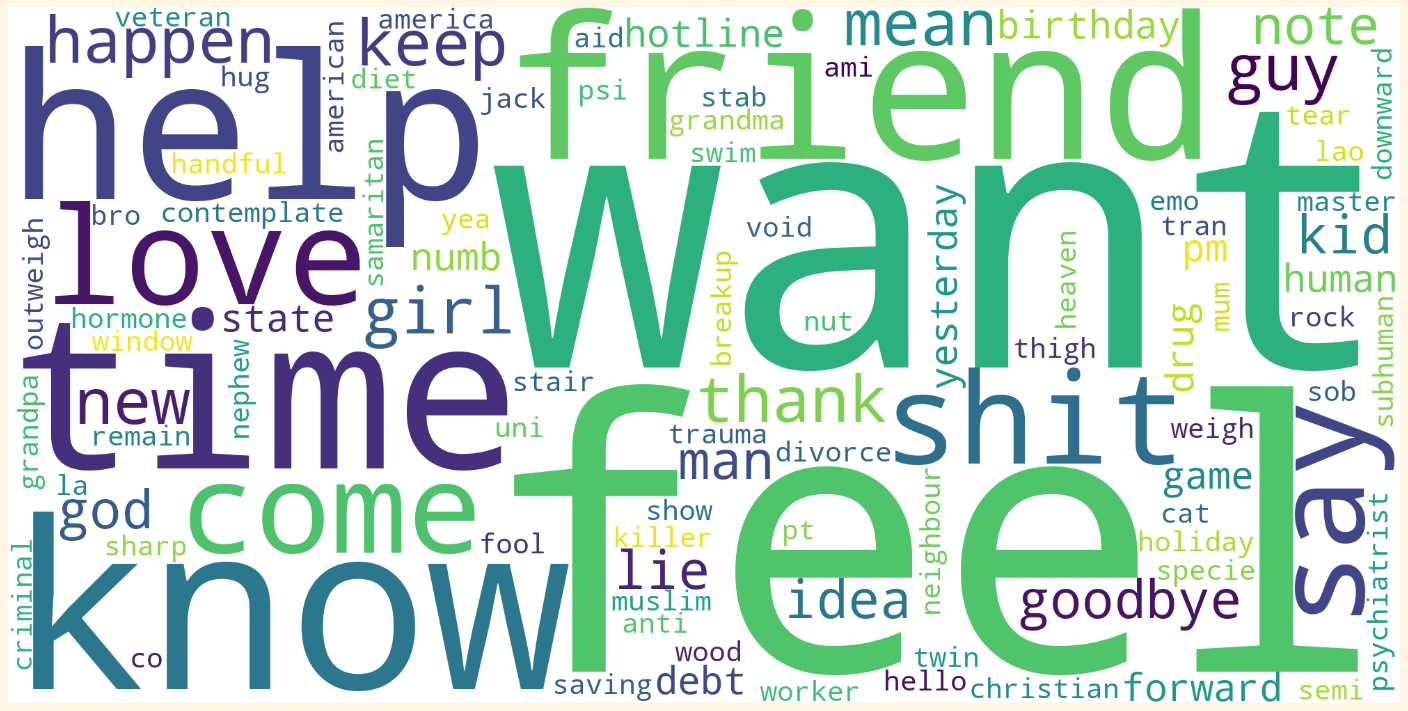

In [154]:

# Wordcloud 
feature_names=token_df['word'].values
wc=WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

In [119]:
train_data_suicidal.loc[:,'cleaned_text'] = train_data_suicidal['cleaned_text'].astype('str')
train_data_suicidal.loc[:,'length'] = train_data_suicidal['cleaned_text'].apply(lambda x: len(x.split()))

In [120]:
train_data_suicidal.head()

,text,class,cleaned_text,length
152171,I think I'm going to end it tonightI don't wan...,suicide,think go end tonight not want failure anymore ...,14
10701,StuckIdk even y I’m posting can’t even explain...,suicide,stuck post not explain gone throw lose lose go...,17
34595,That’s right.I’m a useless attention whore. Te...,suicide,right useless attention whore tell horrible kn...,17
152503,ComplicationsI'm hit with depression every onc...,suicide,complication hit depression fine week maybe ro...,40
16863,Quick Question: Can an individual still be cha...,suicide,quick question individual charge assisted suic...,19


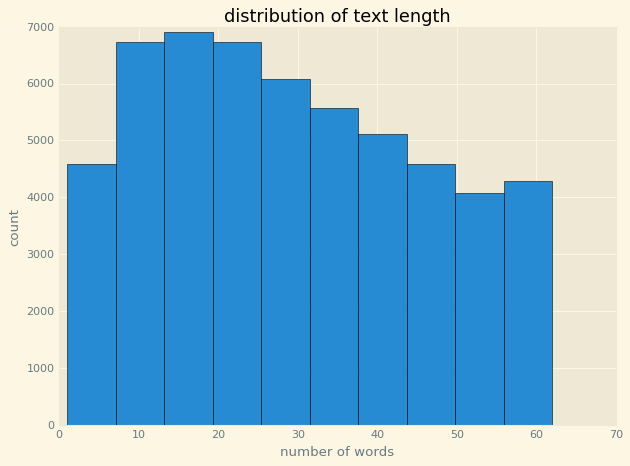

In [153]:
img = train_data_suicidal['length'].plot(kind='hist' ,title = 'distribution of text length' , edgecolor='black')
img.set_xlabel("number of words")
img.set_ylabel("count")
plt.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Polarity Score Distribution

In [163]:
# Polarity score distribution
def get_polarity(text):
  return TextBlob(text).sentiment.polarity
train_data_suicidal.loc[:,'Polarity'] = train_data_suicidal.loc[:,'cleaned_text'].apply(get_polarity)

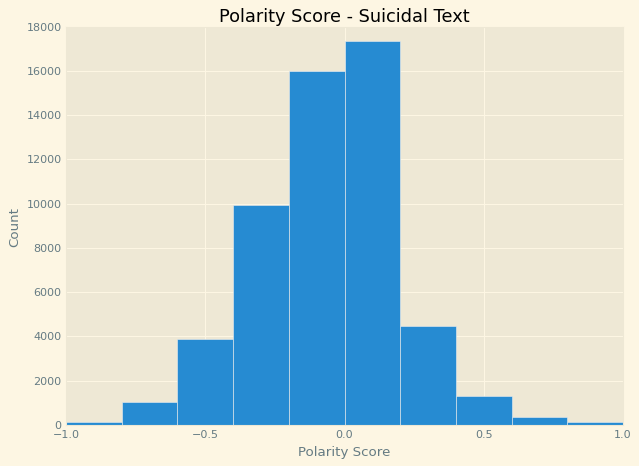

In [164]:
# Plot polarity score graph
ax = train_data_suicidal['Polarity'].plot(kind='hist', title='Polarity Score - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()
     

In [166]:
#Remove more stop words and do bigram
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
train_data_suicidal.loc[:,'without_stopwords'] = train_data_suicidal.loc[:,'cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_suicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [167]:
bigram_df

,Bigram,Count
0,"(feel, like)",10783
1,"(want, die)",5517
2,"(want, kill)",2402
3,"(want, end)",1981
4,"(commit, suicide)",1715
5,"(want, live)",1655
6,"(suicidal, thought)",1600
7,"(need, help)",1527
8,"(end, life)",1484
9,"(year, old)",1306


<Axes: >

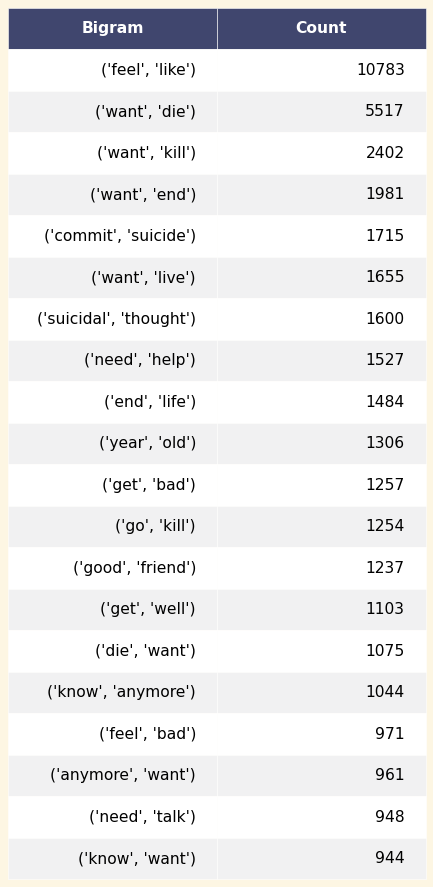

In [168]:

#To make the table nicer
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(bigram_df, header_columns=0, col_width=3)
     

## Non-suicidal Text

In [169]:

tokenizer_nonsuicidal = Tokenizer()
tokenizer_nonsuicidal.fit_on_texts(train_data_nonsuicidal["text"])

In [170]:
tokenizer_nonsuicidal.word_counts.items()

odict_items([('i’m', 13907), ('so', 30188), ('fucking', 5202), ('tired', 1084), ('but', 28213), ('i', 149268), ('don’t', 6668), ('want', 11334), ('to', 89798), ('go', 6718), ('sleep', 2380), ('i’ll', 1417), ('just', 29359), ('keep', 1731), ('manically', 1), ('shit', 4825), ('posting', 1314), ('what', 15640), ('keeps', 387), ('you', 42180), ('up', 10335), ('at', 11387), ('night', 1956), ('why', 8025), ('is', 37310), ('it', 51408), ('that', 30278), ('can’t', 2285), ('bad', 3777), ('dreams', 257), ('stress', 242), ('hormones', 38), ('😂', 59), ('for', 29731), ('those', 1585), ('of', 38808), ('who', 7091), ('have', 25475), ('a', 80604), ('hard', 1724), ('time', 7611), ('falling', 185), ('asleep', 480), ('do', 20570), ('think', 7510), ('caused', 89), ('are', 16221), ('some', 9333), ('artists', 116), ('like', 27033), ('adele', 2), ('read', 1312), ('the', 74684), ('title', 993), ('did', 4274), ('miss', 817), ('skirt', 133), ('trend', 101), ('can', 11600), ('someone', 6041), ('has', 5284), ('an

In [171]:
word_freq_nonsuicidal = pd.DataFrame(tokenizer_nonsuicidal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_nonsuicidal.head()

,word,count
5,i,149268
8,to,89798
61,and,87819
38,a,80604
52,the,74684


## Word Frequency Bar Graph

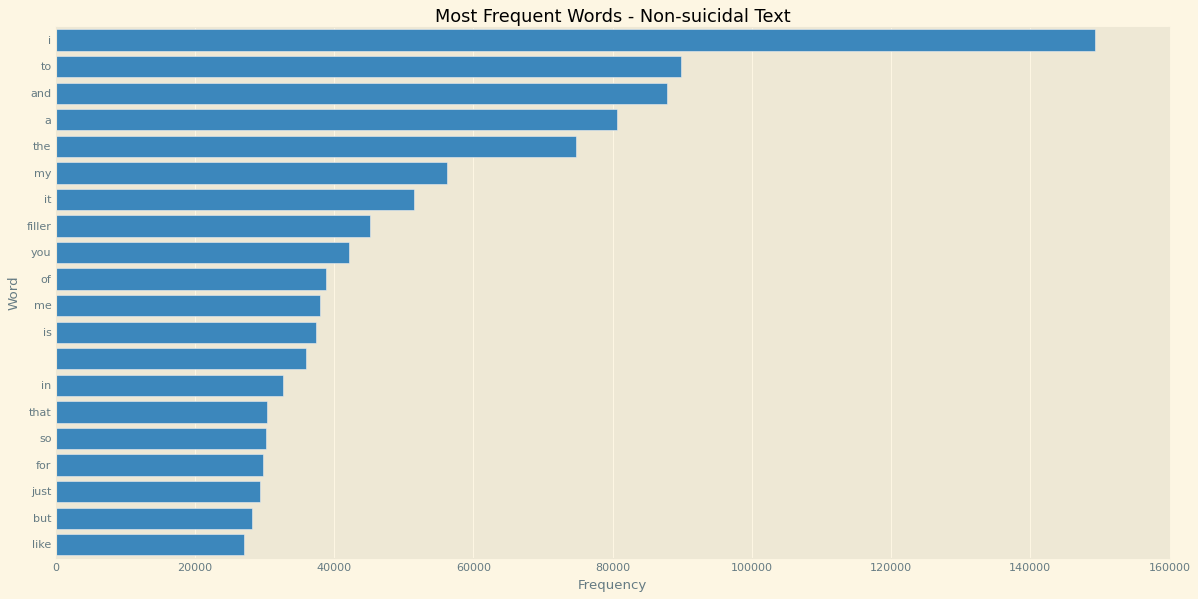

In [172]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_nonsuicidal.iloc[:20])
plt.title('Most Frequent Words - Non-suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

## Word Cloud for non suicidal data

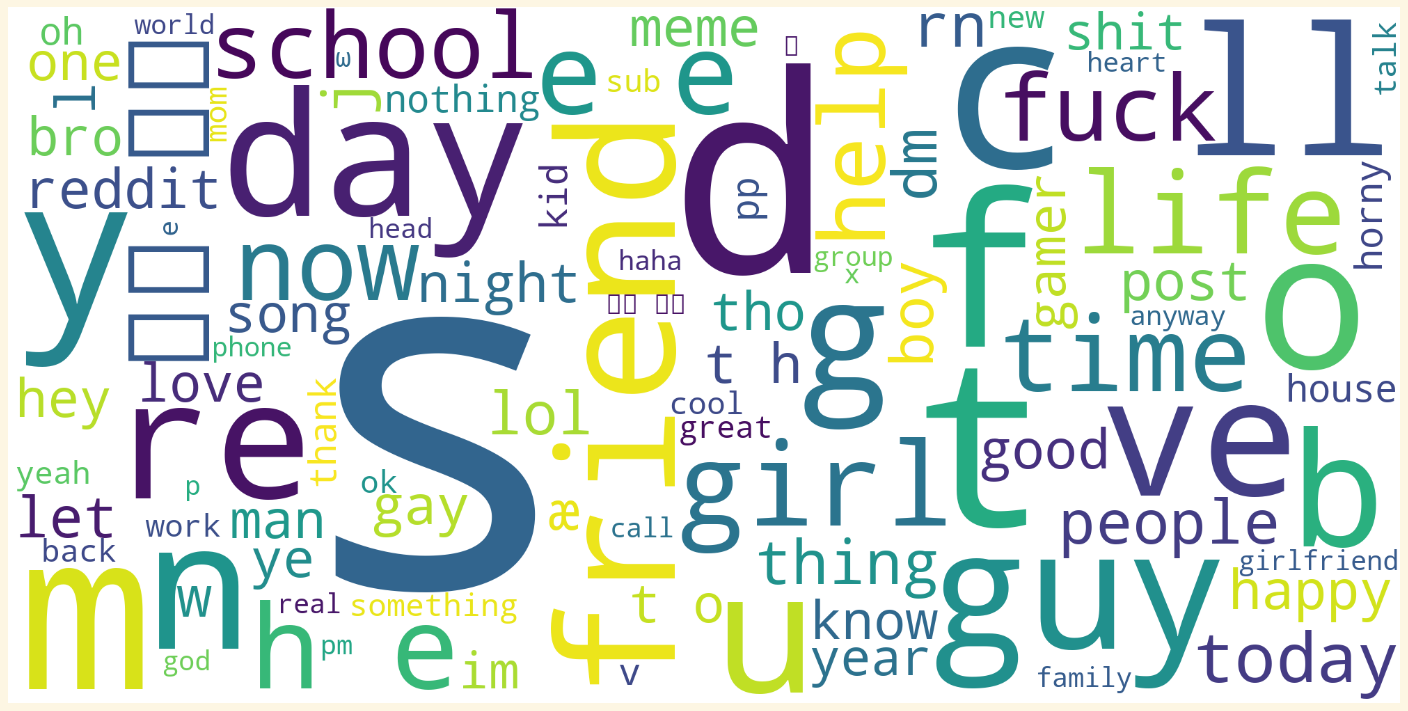

In [173]:
# Wordcloud  
feature_names_nonsuicidal = word_freq_nonsuicidal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_nonsuicidal))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

## Distribution of Text Length

In [175]:
# Get average text length
train_data_nonsuicidal.loc[:,'cleaned_text'] = train_data_nonsuicidal['cleaned_text'].astype('str')
train_data_nonsuicidal.loc[:,'length'] = train_data_nonsuicidal.loc[:,'cleaned_text'].apply(lambda x: len(x.split()))

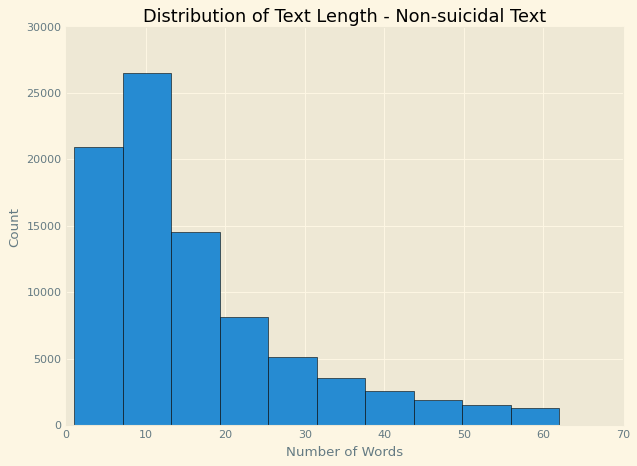

In [176]:
# Plot distribution of text length
ax = train_data_nonsuicidal['length'].plot(kind='hist',title='Distribution of Text Length - Non-suicidal Text', edgecolor='black', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()
     

### Polarity Score Distribution

In [182]:

# Polarity score distribution
train_data_nonsuicidal.loc[:,'cleaned_text'] = train_data_nonsuicidal['cleaned_text'].astype('str')
train_data_nonsuicidal.loc[:,'Polarity'] = train_data_nonsuicidal.loc[:,'cleaned_text'].apply(get_polarity)

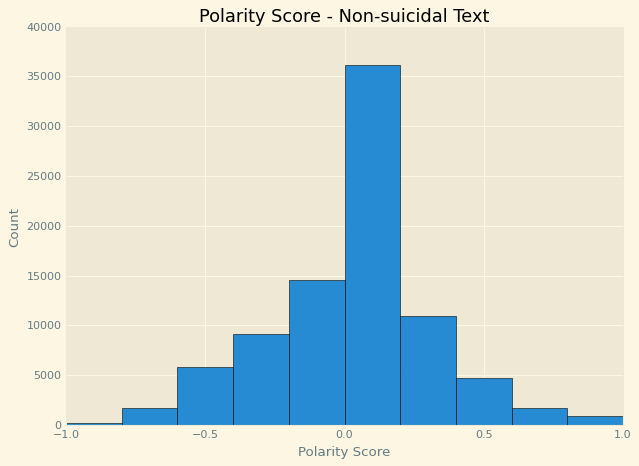

In [183]:
# Plot polarity score graph
ax = train_data_nonsuicidal['Polarity'].plot(kind='hist', title='Polarity Score - Non-suicidal Text', edgecolor="black", figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

## Bi - gram

<Axes: >

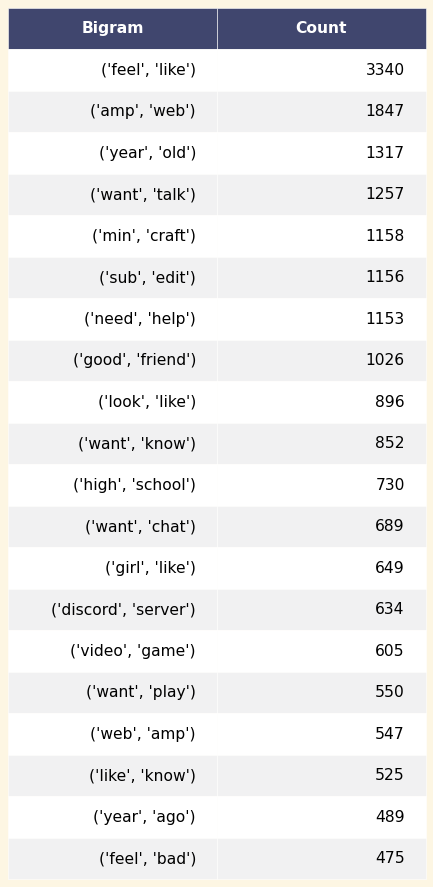

In [185]:

#Remove more stop words and do bigram
stop_words = stopwords.words('english')
train_data_nonsuicidal.loc[:,'without_stopwords'] = train_data_nonsuicidal.loc[:,'cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_nonsuicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

render_mpl_table(bigram_df, header_columns=0, col_width=3)